In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#from scipy.integrate import solve_ivp

In [2]:
#any transformation can be done with a combination of the above 3

def spherical_to_cartesian(r, theta, phi):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z


def cylindrical_to_spherical(rho, psi, z):
    r = np.sqrt(rho**2 + z**2)
    theta = np.arctan2(rho, z) if r != 0 else 0
    phi = psi
    return r, theta, phi

def cartesian_to_cylindrical(x, y, z):
    rho = np.sqrt(x**2 + y**2)
    psi = np.arctan2(y, x)
    return rho, psi, z



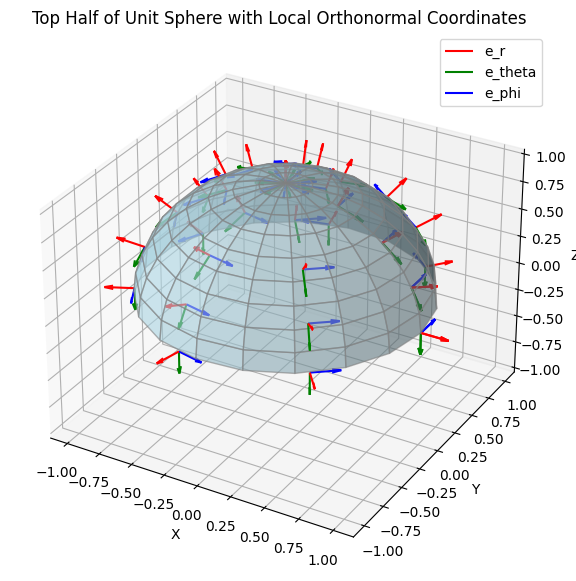

In [3]:
def local_orthonormal_coords(theta, phi):
    """
    Compute the local orthonormal coordinate system on the unit sphere at (theta, phi).
    """
    # Radial unit vector
    e_r = np.array([
        np.sin(theta) * np.cos(phi),
        np.sin(theta) * np.sin(phi),
        np.cos(theta)
    ])
    
    # Polar unit vector
    e_theta = np.array([
        np.cos(theta) * np.cos(phi),
        np.cos(theta) * np.sin(phi),
        -np.sin(theta)
    ])
    
    # Azimuthal unit vector
    e_phi = np.array([
        -np.sin(phi),
        np.cos(phi),
        0
    ])
    
    return e_r, e_theta, e_phi


# Generate the top half of a unit sphere
theta_vals = np.linspace(0, np.pi / 2, 10)  # Polar angles
phi_vals = np.linspace(0, 2 * np.pi, 20)   # Azimuthal angles
theta, phi = np.meshgrid(theta_vals, phi_vals)
x = np.sin(theta) * np.cos(phi)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, color='lightblue', alpha=0.6, edgecolor='gray')

# Select a few points on the sphere to display local coordinate systems
sample_thetas = np.linspace(0, np.pi / 2, 5)
sample_phis = np.linspace(0, 2 * np.pi, 8)

first_point = True  # To label the vectors only for the first point
for theta in sample_thetas:
    for phi in sample_phis:
        # Compute the point on the sphere
        r = np.array([
            np.sin(theta) * np.cos(phi),
            np.sin(theta) * np.sin(phi),
            np.cos(theta)
        ])
        
        # Get local orthonormal basis
        e_r, e_theta, e_phi = local_orthonormal_coords(theta, phi)
        
        # Plot the local basis vectors
        ax.quiver(*r, *e_r, color='red', length=0.2, normalize=True, label='e_r' if first_point else "")
        ax.quiver(*r, *e_theta, color='green', length=0.2, normalize=True, label='e_theta' if first_point else "")
        ax.quiver(*r, *e_phi, color='blue', length=0.2, normalize=True, label='e_phi' if first_point else "")
        first_point = False  # Disable further labeling

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlim(-1, 1)
ax.set_zlabel('Z')
ax.set_title('Top Half of Unit Sphere with Local Orthonormal Coordinates')
ax.legend(loc='upper right')
plt.show()

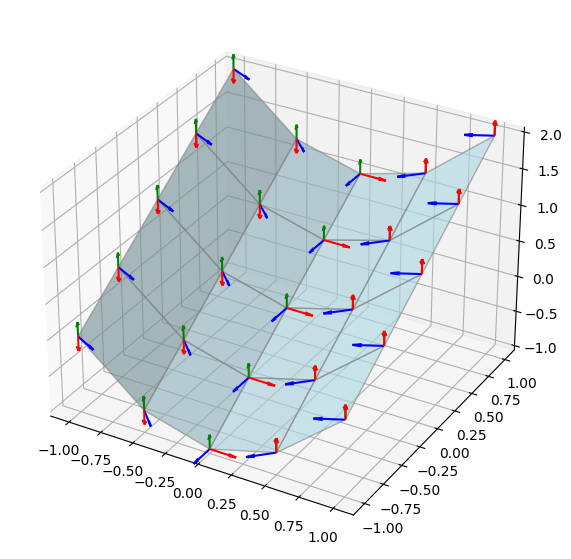

In [4]:
def generate_local_coords(f, x_vals, y_vals, dx=1e-4, dy=1e-4):
    Z = f(x_vals, y_vals)
    
    # Compute the gradients (∂f/∂x) and (∂f/∂y)
    fx = np.gradient(Z, axis=1, edge_order=2) / dx  # Gradient with respect to x
    fy = np.gradient(Z, axis=0, edge_order=2) / dy  # Gradient with respect to y
    
    # Tangent vectors in x and y directions
    e_x = np.stack([np.ones_like(fx), np.zeros_like(fx), fx], axis=0)     #like matches shape
    e_y = np.stack([np.zeros_like(fy), np.ones_like(fy), fy], axis=0)
    
    # Compute the normal vector (gradient of surface)
    e_z = np.array([-fx, -fy, np.ones_like(fx)])
    
    # Normalize the normal vector
    norm_e_z = np.linalg.norm(e_z, axis=0)
    e_z = e_z / norm_e_z
    
    # Normalize the tangent vectors (optional)
    e_x = e_x / np.linalg.norm(e_x, axis=0)
    e_y = e_y / np.linalg.norm(e_y, axis=0)
    
    return e_x, e_y, e_z


#testing the above function

def addfunc(x, y):
    return (x**2+y)

xvals = np.linspace(-1,1,5)
yvals = np.linspace(-1,1,5)

xmvals, ymvals = np.meshgrid(xvals, yvals)      #necessary for plot surface
zmvals = addfunc(xmvals, ymvals)
r = np.column_stack((xmvals, ymvals, zmvals))

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xmvals, ymvals, zmvals, color='lightblue', alpha=0.6, edgecolor='gray')

e_x, e_y, e_z = generate_local_coords(addfunc, xmvals, ymvals )

# Plot the local basis vectors
ax.quiver(xmvals, ymvals, zmvals, e_x[0], e_x[1], e_x[2], color='red', length=0.2, normalize=True)
ax.quiver(xmvals, ymvals, zmvals, e_y[0], e_y[1], e_y[2], color='green', length=0.2, normalize=True)
ax.quiver(xmvals, ymvals, zmvals, e_z[0], e_z[1], e_z[2], color='blue', length=0.2, normalize=True)

In [46]:
def parallel_transport(theta0, phi0, alpha, beta, steps=25):
    # Create theta points for the geodesic path
    theta = np.linspace(theta0, np.pi / 2, steps)
    print(theta)
    
    # Initialize the transported vector
    n_theta = alpha
    n_phi = beta

    # Arrays to store vector components along the path
    n_theta_arr = []
    n_phi_arr = []

    # Perform parallel transport along the geodesic
    for t in theta:
        n_theta_arr.append(n_theta)
        n_phi_arr.append(n_phi)

        # Update the vector using the parallel transport equations
        dphi = -(n_phi / np.tan(t)) * (theta[1] - theta[0])                    #equation 22 on the lecture notes
        n_phi += dphi


    n_theta_arr = np.array(n_theta_arr)
    n_phi_arr = np.array(n_phi_arr)

    # Compute the coordinates of the geodesic on the sphere
    x = np.sin(theta) * np.cos(phi0)
    y = np.sin(theta) * np.sin(phi0)
    z = np.cos(theta)

    # Compute vector components in 3D space, multiplying expressions of unit vectors in Cartesian by coordinates
    vec_x = (np.cos(theta)*np.cos(phi0)* n_theta_arr) + (-np.sin(phi0)*n_phi_arr)
    
    vec_y = (np.cos(theta)*np.sin(phi0)* n_theta_arr) + (np.cos(phi0)*n_phi_arr)
    
    vec_z = (-np.sin(phi0)* theta)
    normalize = np.sqrt(vec_x**2+vec_y**2+vec_z**2)

    return x, y, z, vec_x/normalize, vec_y/normalize, vec_z/normalize


[0.62831853 0.66758844 0.70685835 0.74612826 0.78539816 0.82466807
 0.86393798 0.90320789 0.9424778  0.9817477  1.02101761 1.06028752
 1.09955743 1.13882734 1.17809725 1.21736715 1.25663706 1.29590697
 1.33517688 1.37444679 1.41371669 1.4529866  1.49225651 1.53152642
 1.57079633]


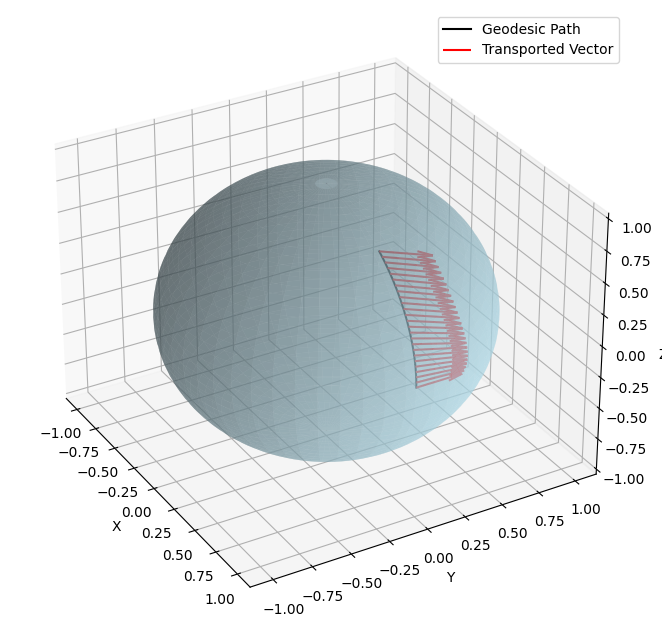

In [50]:
# Initial conditions
alpha = 1.0   # Component along e_theta
beta = 1.0    # Component along e_phi
theta0 = np.pi / 5  # Initial polar angle
phi0 = 0  # Initial azimuthal angle

# Perform parallel transport
x, y, z, vec_x, vec_y, vec_z = parallel_transport(theta0, phi0, alpha, beta)
# Plot the results
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x_sphere = np.outer(np.sin(v), np.cos(u))
y_sphere = np.outer(np.sin(v), np.sin(u))
z_sphere = np.outer(np.cos(v), np.ones_like(u))
ax.plot_surface(x_sphere, y_sphere, z_sphere, color='lightblue', alpha=0.5)

# Plot the geodesic path
ax.plot(x, y, z, color='black', label='Geodesic Path')

# Plot the transported vector along the path
ax.quiver(x, y, z, vec_x, vec_y, vec_z, color='red', label='Transported Vector', length=0.3)

# Set labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(azim=-30)  #changes camera position in degrees
ax.legend()
plt.show()

In [63]:

def parallel_transport2(theta0, alpha, beta, steps=25):
    # Create theta points for the geodesic path
    phi = np.linspace(0, np.pi * 2, num = 25)
    delta_t = np.pi*2/25
    print(phi)
    
    # Initialize the transported vector n
    n_theta = alpha
    n_phi = beta

    # Arrays to store vector components along the path
    n_theta_arr = []
    n_phi_arr = []

    # Perform parallel transport along the geodesic
    for t in phi:
        n_theta_arr.append(n_theta)
        n_phi_arr.append(n_phi)

        # Update the vector using the parallel transport equations
        dn_phi = -n_theta * (1/np.tan(theta0)) * delta_t
        dn_theta = n_phi * np.sin(theta0) * np.cos(theta0) * delta_t

        n_phi += dn_phi
        n_theta += dn_theta

    n_theta_arr = np.array(n_theta_arr)
    n_phi_arr = np.array(n_phi_arr)
         

    # Compute the coordinates of the geodesic on the sphere
    x = np.sin(theta0) * np.cos(phi)
    y = np.sin(theta0) * np.sin(phi)
    z = np.cos(theta0)

    # Compute vector components in 3D space
    vec_x, vec_y, vec_z = spherical_to_cartesian(1, n_phi_arr, n_theta_arr)

     # Compute vector components in 3D space, multiplying expressions of unit vectors in Cartesian by coordinates
    vec_x = (np.cos(theta0)*np.cos(phi)* n_theta_arr) + (-np.sin(phi)*n_phi_arr)
    
    vec_y = (np.cos(theta0)*np.sin(phi)* n_theta_arr) + (np.cos(phi)*n_phi_arr)
    
    vec_z = (-np.sin(phi)* theta)

    normalize = np.sqrt(vec_x**2+vec_y**2+vec_z**2)

    return x, y, z, vec_x/normalize, vec_y/normalize, vec_z/normalize

[0.         0.26179939 0.52359878 0.78539816 1.04719755 1.30899694
 1.57079633 1.83259571 2.0943951  2.35619449 2.61799388 2.87979327
 3.14159265 3.40339204 3.66519143 3.92699082 4.1887902  4.45058959
 4.71238898 4.97418837 5.23598776 5.49778714 5.75958653 6.02138592
 6.28318531]


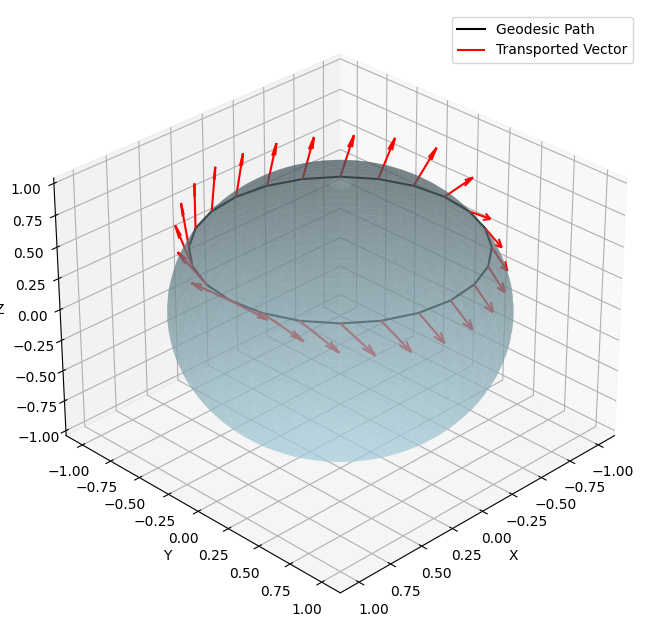

In [64]:
# Initial conditions
alpha = 1.0   # Component along e_theta
beta = 0.0    # Component along e_phi
theta0 = np.pi / 3  # Initial polar angle
phi0 = 0  # Initial azimuthal angle

# Perform parallel transport
x, y, z, vec_x, vec_y, vec_z = parallel_transport2(theta0, phi0, alpha, beta)
# Plot the results
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x_sphere = np.outer(np.sin(v), np.cos(u))
y_sphere = np.outer(np.sin(v), np.sin(u))
z_sphere = np.outer(np.cos(v), np.ones_like(u))
ax.plot_surface(x_sphere, y_sphere, z_sphere, color='lightblue', alpha=0.5)

# Plot the geodesic path
ax.plot(x, y, z, color='black', label='Geodesic Path')

# Plot the transported vector along the path
ax.quiver(x, y, z, vec_x, vec_y, vec_z, color='red', label='Transported Vector', length=0.3)

# Set labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(azim=45)  #changes camera position in degrees
ax.legend()
plt.show()


[0.         0.26179939 0.52359878 0.78539816 1.04719755 1.30899694
 1.57079633 1.83259571 2.0943951  2.35619449 2.61799388 2.87979327
 3.14159265 3.40339204 3.66519143 3.92699082 4.1887902  4.45058959
 4.71238898 4.97418837 5.23598776 5.49778714 5.75958653 6.02138592
 6.28318531]
[0.         0.26179939 0.52359878 0.78539816 1.04719755 1.30899694
 1.57079633 1.83259571 2.0943951  2.35619449 2.61799388 2.87979327
 3.14159265 3.40339204 3.66519143 3.92699082 4.1887902  4.45058959
 4.71238898 4.97418837 5.23598776 5.49778714 5.75958653 6.02138592
 6.28318531]
[0.         0.26179939 0.52359878 0.78539816 1.04719755 1.30899694
 1.57079633 1.83259571 2.0943951  2.35619449 2.61799388 2.87979327
 3.14159265 3.40339204 3.66519143 3.92699082 4.1887902  4.45058959
 4.71238898 4.97418837 5.23598776 5.49778714 5.75958653 6.02138592
 6.28318531]
[0.         0.26179939 0.52359878 0.78539816 1.04719755 1.30899694
 1.57079633 1.83259571 2.0943951  2.35619449 2.61799388 2.87979327
 3.14159265 3.40339204 

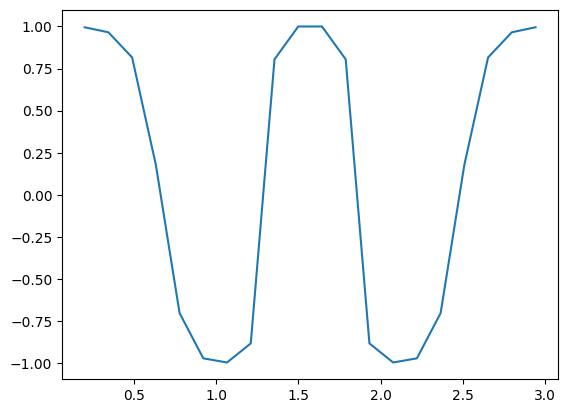

In [65]:
#part g

#Now do the code from the above cell multiple times, and return the resulting inner product of the initial and final veectors

def Holonomy_trends(theta_init):
    # Initial conditions
    alpha = 1.0   # Component along e_theta
    beta = 0.0    # Component along e_phi
    theta0 = theta_init  # Initial polar angle
    phi0 = 0  # Initial azimuthal angle

    # Perform parallel transport
    x, y, z, vec_x, vec_y, vec_z = parallel_transport2(theta0, phi0, alpha, beta)
    
    return vec_x[-1]*vec_x[0] + vec_y[-1]*vec_y[0] +  vec_z[-1]*vec_z[0]     #return the inner product


ht_vals = np.linspace(0.2, np.pi-0.2, 20)

ip_vals = []
for htval in ht_vals:
    ip_vals.append(Holonomy_trends(htval))


plt.plot(ht_vals, ip_vals)


Note, I worked closely with Will Melby on this HW, so we exchanged a lot of code. I adapted a lot of his code for P1, and he adapted a lot of mine for P3.